In [21]:
import os

# os.environ["KERAS_BACKEND"] = "tensorflow''

import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
import keras
from keras import layers

In [22]:
data_dir = Path("./captcha_images_v2/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])
print("Max length for any captcha: ",max_length)

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']
Max length for any captcha:  5


In [23]:
# Mapping characters to integers
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [24]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

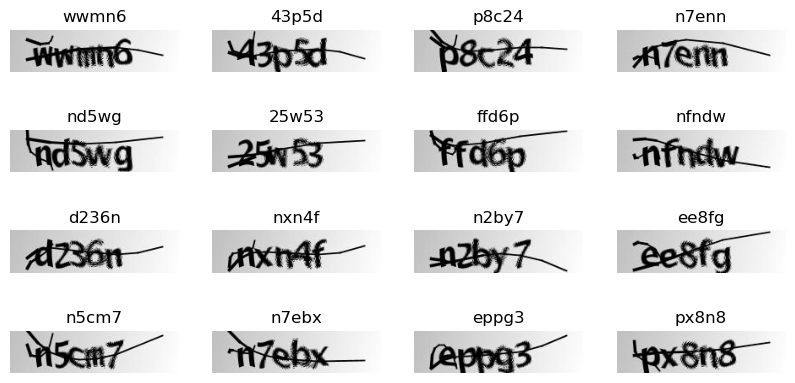

In [25]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()